Data is from the NeurIPS 2022 Ariel Data Challenge on prediciting the atmospheric parameters of exoplanets with various parameters and transit depth spectra. 

2022 Ariel Data Challenge: https://www.ariel-datachallenge.space/

Reference Papers:

https://arxiv.org/abs/2206.14642

https://arxiv.org/abs/2206.14633


# Imports and Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import time
from tqdm import tqdm
from random import randint

from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import SGDOneClassSVM
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import make_pipeline

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Training_Data
N=20000
path ='/content/drive/MyDrive/UF_Courses/2022_fall/2022_fall_ml/student_lecture_10_20_2022/'
aux_train     = pd.read_csv(path+'AuxillaryTable.csv')
aux_train     = aux_train.drop('planet_ID', axis=1)
aux_train     = aux_train[aux_train.keys()][:N]
aux_train_np  = aux_train.to_numpy()[:N,:]
keys          = aux_train.keys()
spec_train    = np.load(path+'spec_matrix.npy')
spec_train1   = np.load(path+'spec_matrix2.npy')
spec_train2   = np.load(path+'spec_matrix3.npy')
#np.save('/content/drive/MyDrive/UF_Courses/2022_fall/2022_fall_ml/student_lecture_10_20_2022/spec_matrix2.npy',spec_train[:int(N/2),:])
#np.save('/content/drive/MyDrive/UF_Courses/2022_fall/2022_fall_ml/student_lecture_10_20_2022/spec_matrix3.npy',spec_train[int(N/2):N,:])
spec_train    = np.vstack([ spec_train1,spec_train2   ])
wave_train    = spec_train[:,:,0]
noise_train   = spec_train[:,:,2]
wavebin_train = spec_train[:,:,3]
spec_train    = spec_train[:,:,1]


targets_train    = pd.read_csv(path+'FM_Parameter_Table.csv')
targets_train    = targets_train.drop('planet_ID', axis=1)
target_keys      = targets_train.keys()
targets_train_np = targets_train.to_numpy()

In [4]:
aux_train.head()

,star_distance,star_mass_kg,star_radius_m,star_temperature,planet_mass_kg,planet_orbital_period,planet_distance,planet_radius_m,planet_surface_gravity
0,100.0510,1.531871e+30,612216000.0,5053.0,4.994682e+25,3.646200,0.042501,1.751739e+07,10.389141
1,28.2938,1.536643e+30,542646000.0,5071.0,3.040857e+25,16.201656,0.114991,1.309706e+07,11.315104
2,258.8930,1.888989e+30,688743000.0,5416.0,9.850620e+25,88.406553,0.381830,2.628654e+07,9.099284
3,1010.2800,2.087830e+30,751356000.0,5900.0,1.954940e+28,3.575320,0.046513,7.040038e+07,251.764117
4,1070.1700,2.028178e+30,953109000.0,5866.0,5.997680e+25,31.588900,0.196877,1.964499e+07,9.919505


In [5]:
targets_train.head()

,planet_temp,log_H2O,log_CO2,log_CH4,log_CO,log_NH3
0,1108.725067,-6.484809,-7.016512,-3.294729,-3.351913,-6.955828
1,636.858130,-8.829193,-8.603965,-5.501124,-4.799371,-6.020019
2,420.527609,-6.626830,-6.420932,-6.755727,-5.318471,-4.695118
3,1370.906116,-7.639372,-5.877303,-4.476840,-5.200010,-6.240726
4,746.170076,-4.172605,-6.899335,-6.360434,-4.140252,-8.896858


In [6]:
for i , key in enumerate(keys):
  print(str(i)+' : '+key)

0 : star_distance
1 : star_mass_kg
2 : star_radius_m
3 : star_temperature
4 : planet_mass_kg
5 : planet_orbital_period
6 : planet_distance
7 : planet_radius_m
8 : planet_surface_gravity


In [7]:
for i , key in enumerate(target_keys):
  print(str(i)+' : '+key)

0 : planet_temp
1 : log_H2O
2 : log_CO2
3 : log_CH4
4 : log_CO
5 : log_NH3


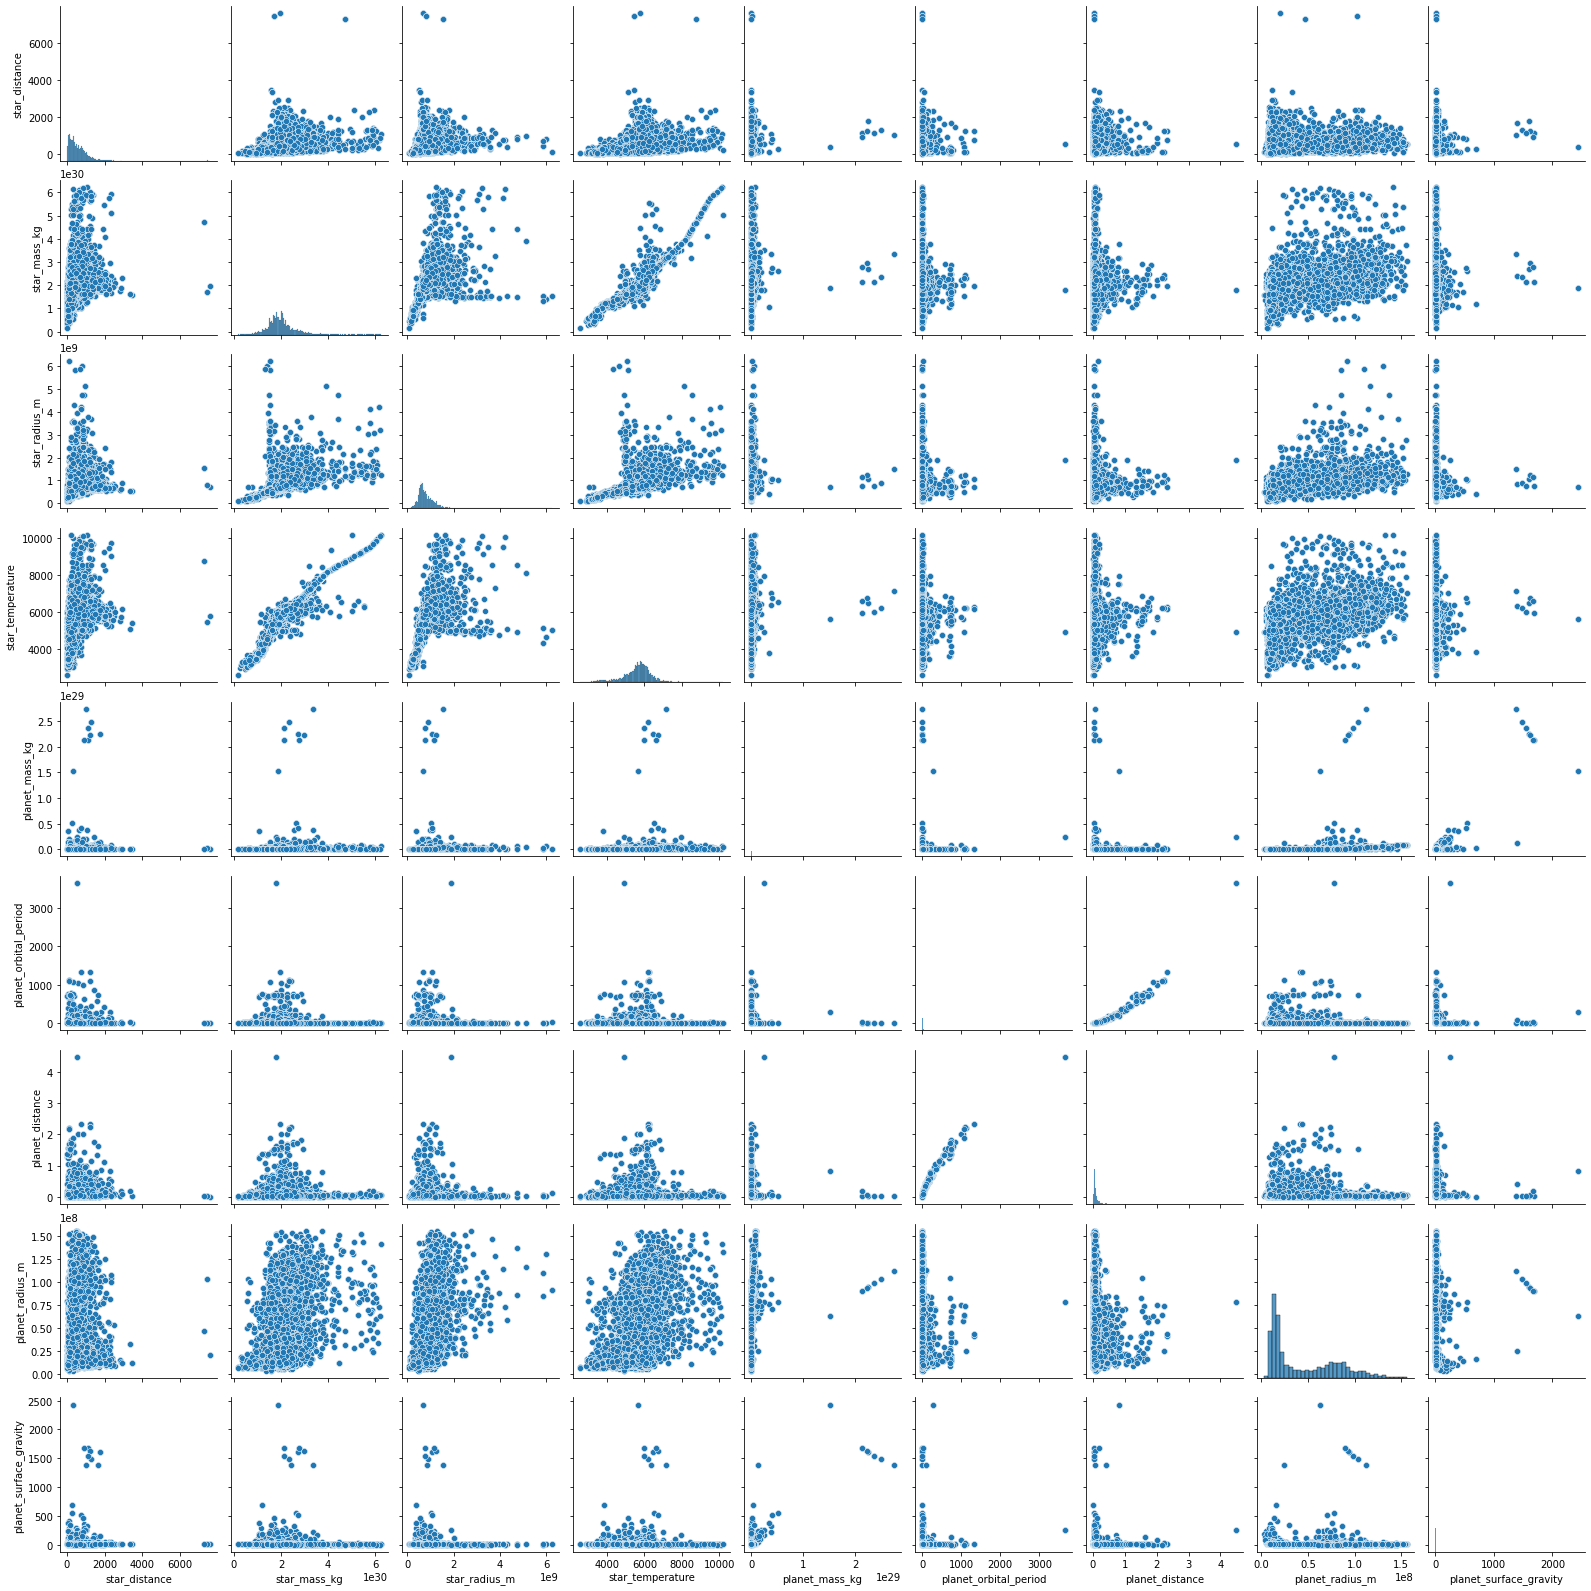

In [8]:
import seaborn as sns

sns.pairplot(aux_train)

Text(0, 0.5, 'Planet Surface Gravity')

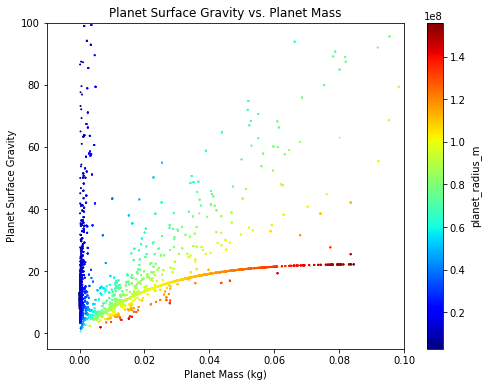

In [9]:
fig = plt.figure(figsize=(8,6))
X = aux_train_np[:,4]*10**(-29)
Y = aux_train_np[:,8]
plt.scatter(X,Y,s=1,cmap='jet',c=aux_train_np[:,7])
plt.colorbar(label=keys[7])
plt.xlim([-0.01,0.1])
plt.ylim([-5,100])
plt.title('Planet Surface Gravity vs. Planet Mass')
plt.xlabel('Planet Mass (kg)')
plt.ylabel('Planet Surface Gravity')

Text(0, 0.5, 'Planet Surface Gravity')

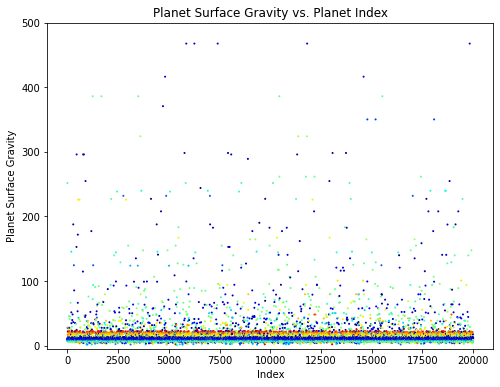

In [10]:
fig = plt.figure(figsize=(8,6))
x = np.linspace(-1,20000,20000)
Y = aux_train_np[:,8]
plt.scatter(x,Y,s=1,cmap='jet',c=aux_train_np[:,7])
plt.ylim([-5,500])
plt.title('Planet Surface Gravity vs. Planet Index')
plt.xlabel('Index')
plt.ylabel('Planet Surface Gravity')

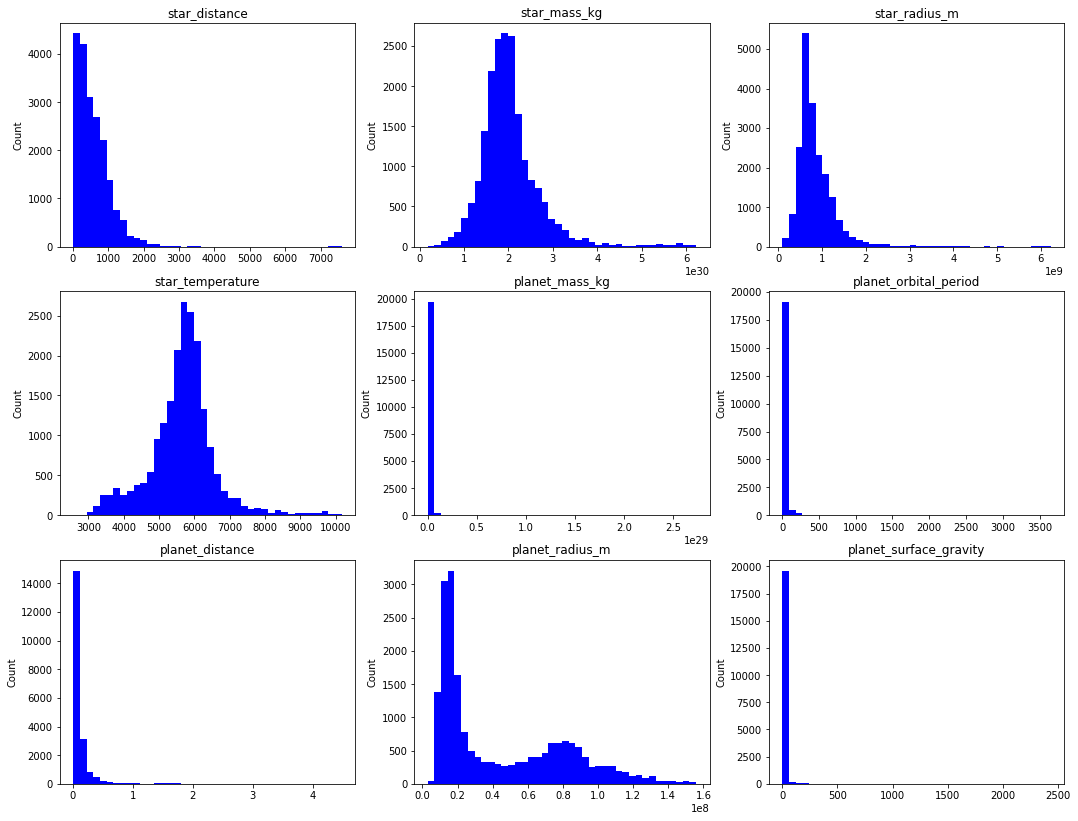

In [11]:
fig = plt.subplots(3,3,figsize=(18,14))
for i in range(len(keys)):
  Y = aux_train_np[:,i]
  plt.subplot(331+i)
  plt.hist(Y,bins=40,color='b')
  plt.title(keys[i])
  #plt.xlabel('Value')
  plt.ylabel('Count')

Text(0, 0.5, 'Max ($\\sqrt{M}$) - $R_p/R_s$')

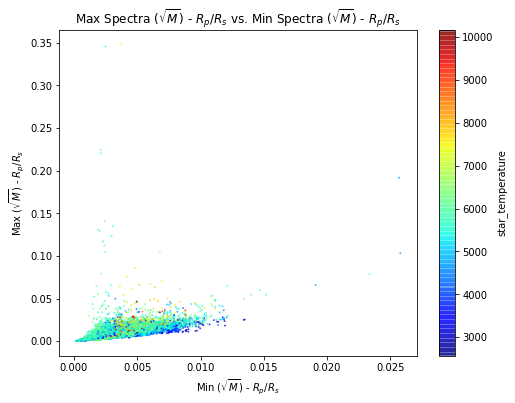

In [12]:
fig = plt.figure(figsize=(8,6))

RpOverRs = np.array([aux_train_np[:,7]/aux_train_np[:,2]]).reshape(-1,)
where = np.where(np.max((np.sqrt(spec_train[:N,:])-RpOverRs[:,None]),axis=1)>1.5)
X = np.min((np.sqrt(spec_train[:N,:])-RpOverRs[:,None]),axis=1)
Y = np.max((np.sqrt(spec_train[:N,:])-RpOverRs[:,None]),axis=1)
Y[where] = np.median(np.sqrt(spec_train[:N,:])-RpOverRs[:,None])
plt.scatter(X,Y,s=1,c=aux_train_np[:,3],cmap='jet',alpha=0.6)
plt.colorbar(label=keys[3])
plt.title('Max Spectra ($\sqrt{M}$) - $R_p/R_s$ vs. Min Spectra ($\sqrt{M}$) - $R_p/R_s$')
plt.xlabel('Min ($\sqrt{M}$) - $R_p/R_s$')
plt.ylabel('Max ($\sqrt{M}$) - $R_p/R_s$')

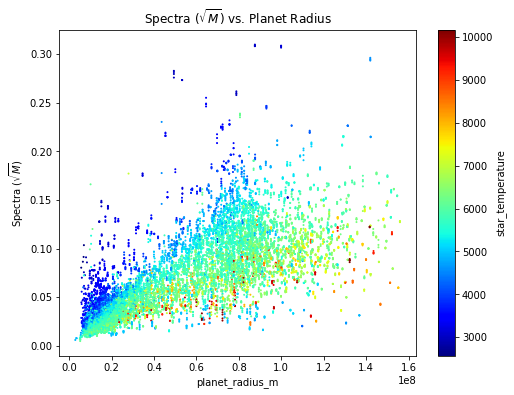

In [13]:
fig = plt.figure(figsize=(8,6))
X = aux_train_np[:,7]
Y = np.sqrt(spec_train[:N,0])
plt.scatter(X,Y,s=1,c=aux_train_np[:,3],cmap='jet')
plt.title('Spectra ($\sqrt{M}$) vs. Planet Radius')
plt.xlabel(keys[7])
plt.ylabel('Spectra ($\sqrt{M}$)')
plt.colorbar(label=keys[3])

Text(0, 0.5, 'star_temperature')

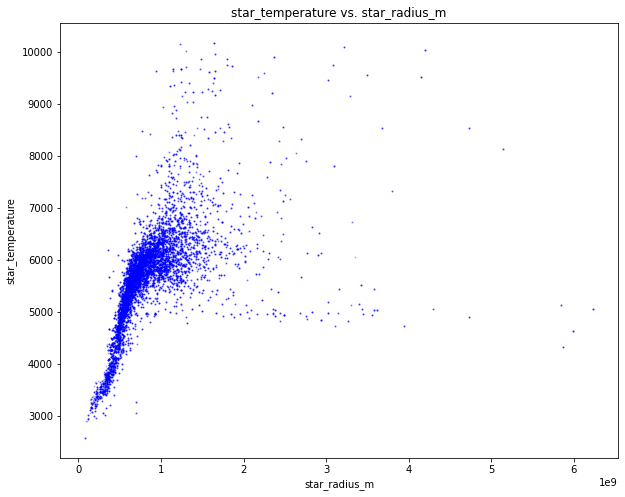

In [14]:
fig = plt.figure(figsize=(10,8))
i = 2; j= 3
X = aux_train_np[:,i]
Y = aux_train_np[:,j]
plt.scatter(X,Y,s=1,c='b',alpha=0.2)
plt.title(keys[j]+' vs. '+keys[i])
plt.xlabel(keys[i])
plt.ylabel(keys[j])

Text(0, 0.5, 'planet_radius_m')

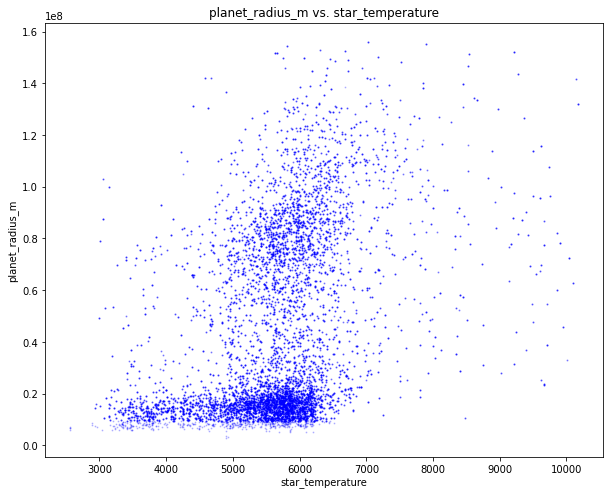

In [15]:
fig = plt.figure(figsize=(10,8))
i=3;j=7
X = aux_train_np[:,i].reshape((-1,1))
Y = aux_train_np[:,j].reshape((-1,1))
plt.scatter(X,Y,s=1,c='b',alpha=0.2)
plt.title(keys[j]+' vs. '+keys[i])
plt.xlabel(keys[i])
plt.ylabel(keys[j])

# Gaussian Mixture

**Gaussian Mixture:** 

In [16]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

# Reinitiate data
X = aux_train_np[:,i].reshape((-1,1))
Y = aux_train_np[:,j].reshape((-1,1))

# Scale data
scalar = StandardScaler()
X = scalar.fit_transform(X).reshape((-1,1))
Y = scalar.fit_transform(Y).reshape((-1,1))
points = np.hstack([ X,Y ])

# Fit the model
gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(points)

GaussianMixture(n_components=3, n_init=10, random_state=42)

Place the anomaly threshold at 2%.

In [17]:
densities = gm.score_samples(points)
density_threshold = np.percentile(densities, 2)
anomalies = points[densities < density_threshold]

In [18]:
X.shape

(20000, 1)

In [19]:
densities[np.where(densities<density_threshold)].shape

(397,)

In [20]:
anomalies.shape

(397, 2)

In [21]:
from matplotlib.colors import LogNorm

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)
    
def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 1
    maxs = X.max(axis=0) + 1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    print('Meshgrid xx shape: ',np.meshgrid(np.linspace(mins[0], maxs[0], resolution),np.linspace(mins[1], maxs[1], resolution))[1].shape)
    
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    print('Levels Z shape: ',Z.shape)

    # Contour map with level colors
    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),levels=np.logspace(0, 2, 15),cmap='viridis')
    plt.colorbar(label='Log Likelihood')
    
    # Level density lines
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),levels=np.logspace(0, 2, 15),
                linewidths=1, colors='black')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)


    # Contour map density regions in red
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    #replot original dataset
    plt.plot(X[:, 0], X[:, 1], '.',markersize=2,c='b')
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel('$x1$', fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

Meshgrid xx shape:  (1000, 1000)
Levels Z shape:  (1000, 1000)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: Log scale: values of z <= 0 have been masked
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: Log scale: values of z <= 0 have been masked


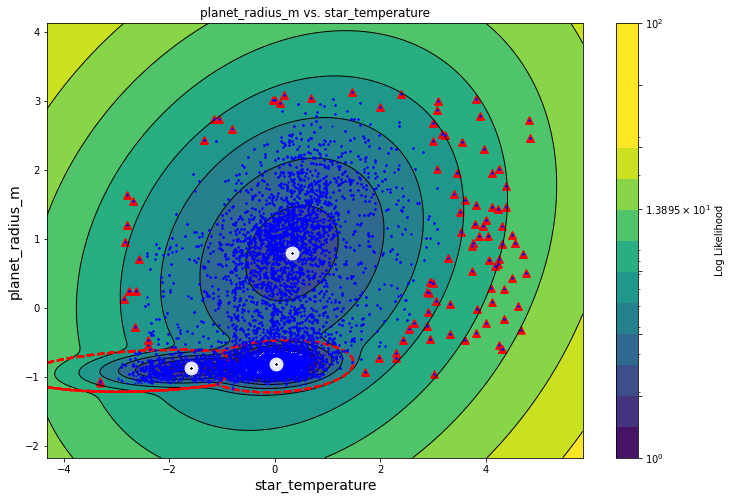

In [22]:
plt.figure(figsize=(12, 8))

plot_gaussian_mixture(gm, points)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='^',s=50)
plt.xlabel(keys[i])
plt.ylabel(keys[j],rotation=90)
plt.title(keys[j]+' vs. '+keys[i])
plt.show()

# Outlier Detection Models

**Robust Covariance:** Elliptic Envelope Method: Assumes Gaussian dstributed inlier data to fit an elliptic envelope with semi-major axis parallel to the greatest density path. When removing the outliers, the Gaussian fit to your data should improve.

**One-Class SVM:**  Rather than using a hyperplane as in SVM with a kernel to map the data from a higher dimension to a lower one to maximize the margin from the support vectors to the kernel values, this method seeks to find a hypersphere that maximizes the margin in the same way while maintaining a minimum in the volume of the sphere. This is ideally around the highest density region. Samples all data points to find the greatest density regions.

**One-Class SVM (SGD):** Same as SM, but rather, samples a random distribution to calculate the density gradient.

**Isolation Forest:** The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. Seeks to 'isolate' those points which fall outside of maximum and minimum limits in the features.

**Local Outlier Factor:** The anomaly score of each sample is called the Local Outlier Factor. It measures the local deviation of the density of a given sample with respect to its neighbors. It is local in that the anomaly score depends on how isolated the object is with respect to the surrounding neighborhood. More precisely, locality is given by k-nearest neighbors, whose distance is used to estimate the local density. By comparing the local density of a sample to the local densities of its neighbors, one can identify samples that have a substantially lower density than their neighbors. These are considered outliers.



In [23]:
n_samples = N
outliers_fraction = 0.1
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

In [24]:
rc = EllipticEnvelope(contamination=outliers_fraction)

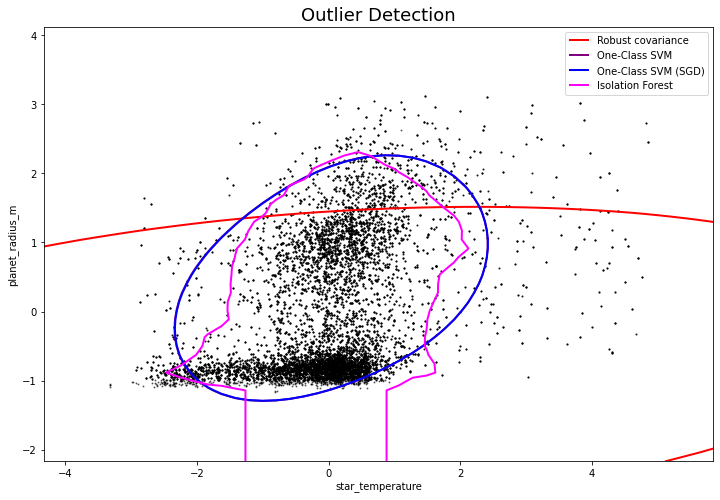

In [25]:
classifiers = {
    "Robust covariance": EllipticEnvelope(contamination=outliers_fraction),
    "One-Class SVM": svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1),
    
    "One-Class SVM (SGD)":  make_pipeline(
            Nystroem(gamma=0.1, random_state=42, n_components=150, kernel='rbf'),
            SGDOneClassSVM(
                nu=outliers_fraction,
                shuffle=True,
                fit_intercept=True,
                random_state=42,
                tol=1e-6)),
    
    "Isolation Forest":
        IsolationForest(contamination=outliers_fraction, random_state=42)
}


# choose a color for each model's contours
colors = ['r','purple','b','magenta','g']
legend1 = {}
legend2 = {}

# Plot the data
fig = plt.figure(figsize=(12,8))  
# Learn a frontier for outlier detection with several classifiers
mins = points.min(axis=0) - 1
maxs = points.max(axis=0) + 1
#resolution=1000
xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0]),np.linspace(mins[1], maxs[1]))

for i, (clf_name, clf) in enumerate(classifiers.items()):
    plt.figure(1)
    clf.fit(points)
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    legend1[clf_name] = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors=colors[i])

legend1_values_list = list(legend1.values())
legend1_keys_list = list(legend1.keys())

#Plot data
plt.title("Outlier Detection",size=18)
plt.scatter(points[:, 0], points[:, 1], color='black',alpha=0.5,s=1)
bbox_args = dict(boxstyle="round", fc="0.8")


plt.xlim((xx.min(), xx.max()))
plt.ylim((yy.min(), yy.max()))
plt.legend((
        legend1_values_list[0].collections[0],
        legend1_values_list[1].collections[0],
        legend1_values_list[2].collections[0],
        legend1_values_list[3].collections[0]),
    (legend1_keys_list[0], legend1_keys_list[1], legend1_keys_list[2], legend1_keys_list[3]) )

plt.ylabel(keys[j],size=10)
plt.xlabel(keys[i],size=10)
plt.show()

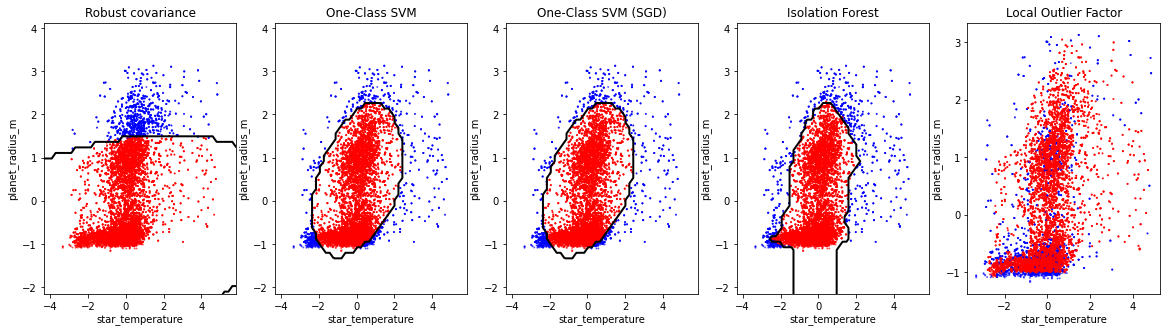

In [26]:

anomaly_algorithms = [
    ("Robust covariance", EllipticEnvelope(contamination=outliers_fraction)),
    ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction, kernel='rbf', gamma=0.1)),
    (
        "One-Class SVM (SGD)",
        make_pipeline(
            Nystroem(gamma=0.1, random_state=42, n_components=150,kernel='rbf'),
            SGDOneClassSVM(
                nu=outliers_fraction,
                shuffle=True,
                fit_intercept=True,
                random_state=42,
                tol=1e-6,
            ),
        ),
    ),
    (
        "Isolation Forest",
        IsolationForest(contamination=outliers_fraction, random_state=42),
    ),
    (
        "Local Outlier Factor",
        LocalOutlierFactor(n_neighbors=35, contamination=outliers_fraction),
    ),
]


mins = points.min(axis=0) - 1
maxs = points.max(axis=0) + 1
xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0]),np.linspace(mins[1], maxs[1]))

fig = plt.subplots(1,5,figsize=(20,5))
rng = np.random.RandomState(42)

plot_num=0
for name, algorithm in anomaly_algorithms:
  algorithm.fit(points)
  plt.subplot(151+plot_num)
  plt.title(name)

  # fit the data and tag outliers
  if name == "Local Outlier Factor":
    y_pred = algorithm.fit_predict(points)
  else:
    y_pred = algorithm.fit(points).predict(points)

  # plot the levels lines and the points
  if name != "Local Outlier Factor":  # LOF does not implement predict
    Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="black")

  colors = np.array(['b', 'r'])
  plt.scatter(points[:, 0], points[:, 1], s=1, alpha=0.5,color=colors[(y_pred +1) // 2])

  plot_num += 1
  plt.xlabel(keys[i])
  plt.ylabel(keys[j])
plt.show()

# Local Outlier Factor (Best Result of the above)

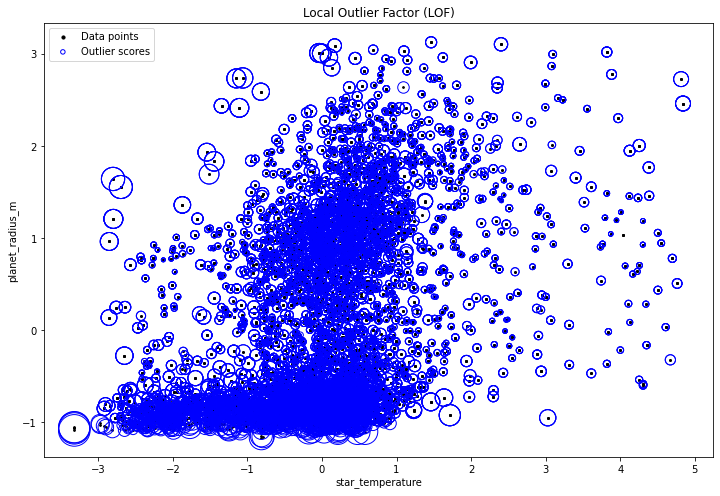

In [27]:
fig = plt.figure(figsize=(12,8))
np.random.seed(42)
# fit the model for outlier detection (default)
clf = LocalOutlierFactor(n_neighbors=35, contamination=outliers_fraction)
# use fit_predict to compute the predicted labels of the training samples
# (when LOF is used for outlier detection, the estimator has no predict,
# decision_function and score_samples methods).
y_pred = clf.fit_predict(points)
X_scores = clf.negative_outlier_factor_

plt.title("Local Outlier Factor (LOF)")
plt.scatter(points[:, 0], points[:, 1], color="k", s=3.0, label="Data points")
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(
    points[:, 0],
    points[:, 1],
    s=1000 * radius,
    edgecolors="b",
    facecolors="none",
    label="Outlier scores",
)
plt.axis("tight")
legend = plt.legend(loc="upper left")
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.xlabel(keys[i])
plt.ylabel(keys[j])
plt.show()

# DBSCAN and OPTICS

In [28]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

In [29]:
db = DBSCAN(eps=0.3, min_samples=15).fit(points)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(points, labels))

Estimated number of clusters: 4
Estimated number of noise points: 186
Silhouette Coefficient: 0.397


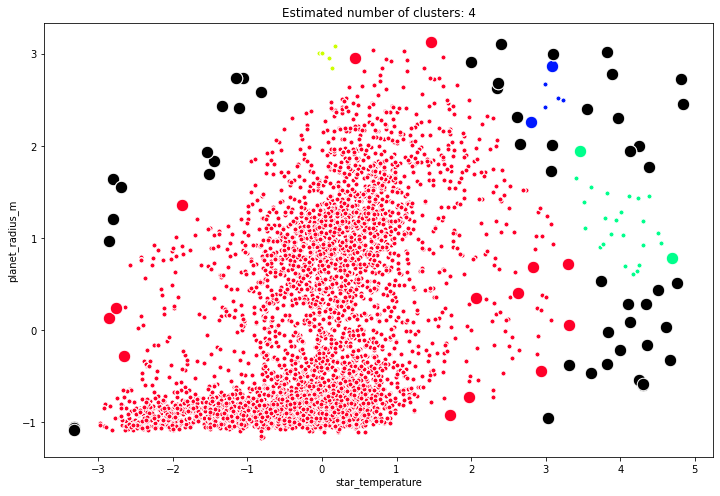

In [30]:
fig = plt.figure(figsize=(12,8))
unique_labels = set(labels)
colors = [plt.cm.gist_rainbow(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = points[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        ".",
        markerfacecolor=tuple(col),
        markeredgecolor="w",
        markersize=10
    )

    xy = points[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        ".",
        markerfacecolor=tuple(col),
        markeredgecolor="w",
        markersize=25
    )
plt.xlabel(keys[i])
plt.ylabel(keys[j])
plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

# Higher Dimesnional One-Class SVM (SGD) with a RBF Kernel

Text(0, 0.5, 'Max ($\\sqrt{M}$) - $R_p/R_s$')

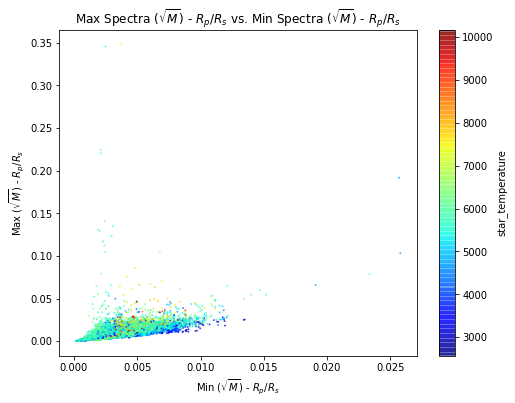

In [31]:
fig = plt.figure(figsize=(8,6))

RpOverRs = np.array([aux_train_np[:,7]/aux_train_np[:,2]]).reshape(-1,)
where = np.where(np.max((np.sqrt(spec_train[:N,:])-RpOverRs[:,None]),axis=1)>1.5)
X = np.min((np.sqrt(spec_train[:N,:])-RpOverRs[:,None]),axis=1)
Y = np.max((np.sqrt(spec_train[:N,:])-RpOverRs[:,None]),axis=1)
Y[where] = np.median(np.sqrt(spec_train[:N,:])-RpOverRs[:,None])
plt.scatter(X,Y,s=1,c=aux_train_np[:,3],cmap='jet',alpha=0.6)
plt.colorbar(label=keys[3])
plt.title('Max Spectra ($\sqrt{M}$) - $R_p/R_s$ vs. Min Spectra ($\sqrt{M}$) - $R_p/R_s$')
plt.xlabel('Min ($\sqrt{M}$) - $R_p/R_s$')
plt.ylabel('Max ($\sqrt{M}$) - $R_p/R_s$')

In [32]:
from sklearn.model_selection import train_test_split

X = spec_train[:N,:].reshape((-1,1))
Y = targets_train_np[:N,:].reshape((-1,1))


scalar = StandardScaler()
X = scalar.fit_transform(X).reshape((N,52))
Y = scalar.fit_transform(Y).reshape((N,6))


x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0)


svm_sgd = make_pipeline(
            Nystroem(gamma=0.1, random_state=42, n_components=150,kernel='rbf'),
            SGDOneClassSVM(
                nu=outliers_fraction,
                shuffle=True,
                fit_intercept=True,
                random_state=42,
                tol=1e-6))
svm_sgd.fit(y_train)

Pipeline(steps=[('nystroem',
                 Nystroem(gamma=0.1, n_components=150, random_state=42)),
                ('sgdoneclasssvm',
                 SGDOneClassSVM(nu=0.1, random_state=42, tol=1e-06))])

In [33]:
y_pred_train = svm_sgd.predict(y_train)
y_pred_test = svm_sgd.predict(y_test)


train_outliers = y_pred_train[y_pred_train == -1].size
test_outliers = y_pred_test[y_pred_test == -1].size

print('Training Error: ',train_outliers )
print('Testing Error: ',test_outliers)

Training Error:  1373
Testing Error:  455


# Novelty Specific Example Using SVM

Link to Example: https://scikit-learn.org/stable/auto_examples/svm/plot_oneclass.html

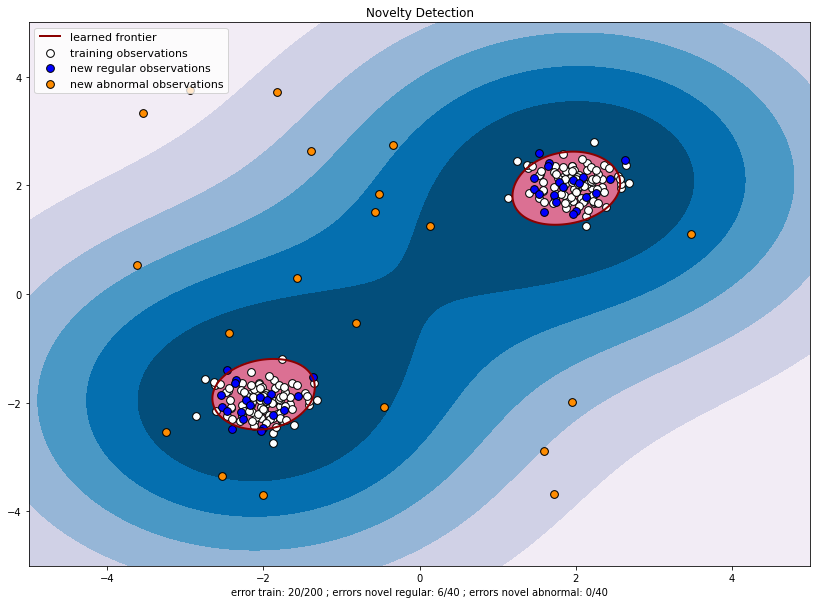

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import svm

xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
# Generate train data
X = 0.3 * np.random.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * np.random.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

# fit the model
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

# plot the line, the points, and the nearest vectors to the plane
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
fig = plt.figure(figsize=(14,10))
plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="darkred")
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors="palevioletred")

s = 60
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c="white", s=s, edgecolors="k")
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c="b", s=s, edgecolors="k")
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c="darkorange", s=s, edgecolors="k")
plt.axis("tight")
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend(
    [a.collections[0], b1, b2, c],
    [
        "learned frontier",
        "training observations",
        "new regular observations",
        "new abnormal observations",
    ],
    loc="upper left",
    prop=matplotlib.font_manager.FontProperties(size=11),
)
plt.xlabel(
    "error train: %d/200 ; errors novel regular: %d/40 ; errors novel abnormal: %d/40"
    % (n_error_train, n_error_test, n_error_outliers)
)
plt.show()